## Import Modules

In [96]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from PIL import Image
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Load the Dataset

In [97]:
# DATASET = 'affectnet'
# DATASET = 'fer2013_balanced'
# DATASET = 'mma'
# DATASET = 'merged_dataset'

DATASET = 'balanced_filtered_FER2013'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [98]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [99]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/balanced_filtered_FER2013/train/disgust\...,disgust
1,input/balanced_filtered_FER2013/train/fear\Tra...,fear
2,input/balanced_filtered_FER2013/train/happy\Tr...,happy
3,input/balanced_filtered_FER2013/train/fear\fea...,fear
4,input/balanced_filtered_FER2013/train/happy\Tr...,happy


In [100]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/balanced_filtered_FER2013/test/happy\Tra...,happy
1,input/balanced_filtered_FER2013/test/happy\Pri...,happy
2,input/balanced_filtered_FER2013/test/sad\Publi...,sad
3,input/balanced_filtered_FER2013/test/angry\Tra...,angry
4,input/balanced_filtered_FER2013/test/neutral\P...,neutral


In [101]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/balanced_filtered_FER2013/valid/sad\Trai...,sad
1,input/balanced_filtered_FER2013/valid/sad\Publ...,sad
2,input/balanced_filtered_FER2013/valid/happy\Tr...,happy
3,input/balanced_filtered_FER2013/valid/happy\Tr...,happy
4,input/balanced_filtered_FER2013/valid/surprise...,surprise


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

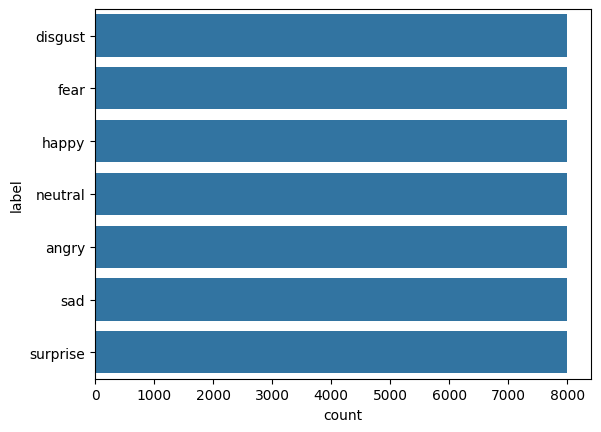

In [102]:
sns.countplot(train['label'])

## Grid of dataset images

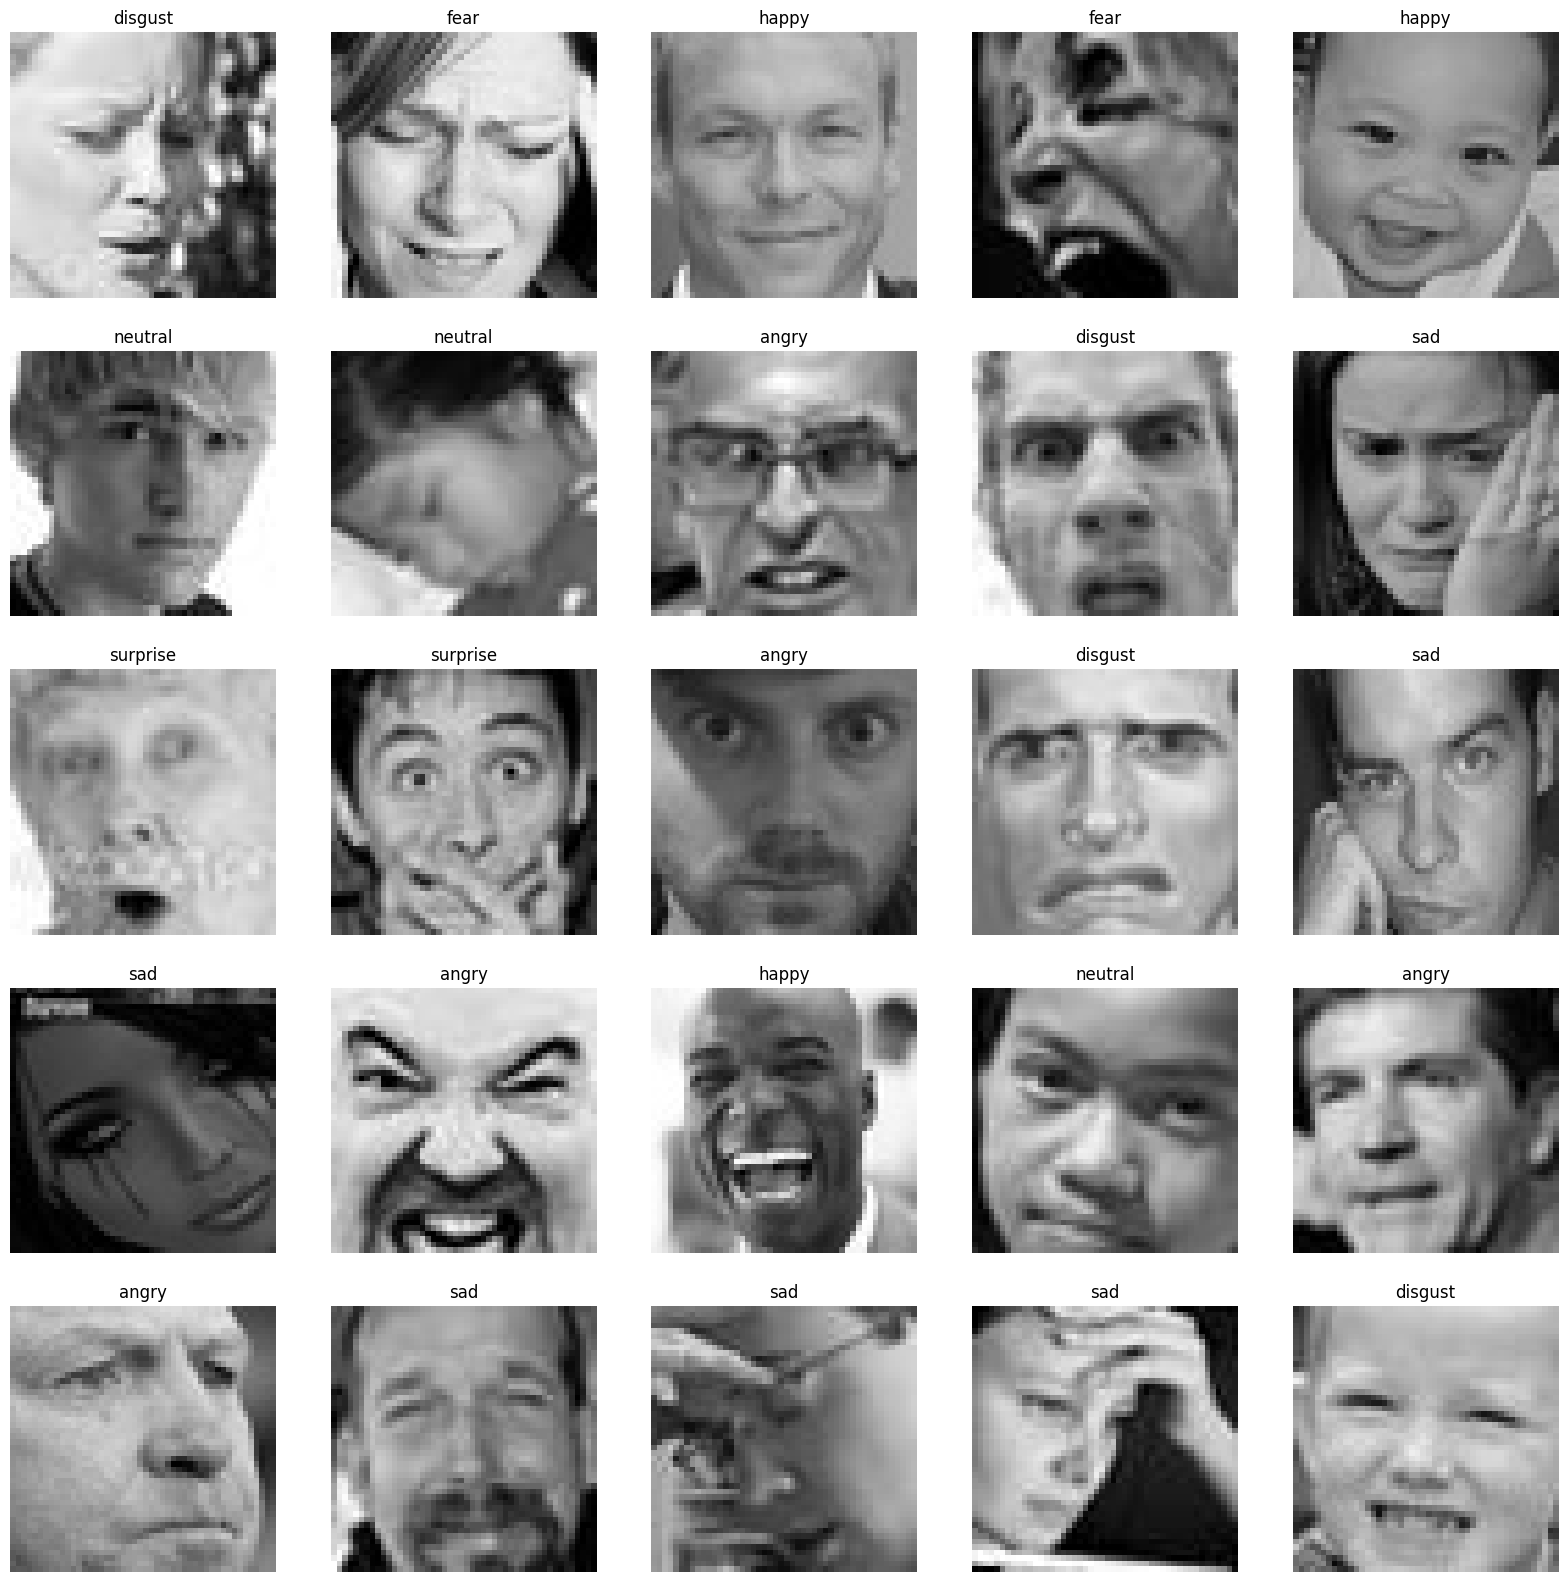

In [103]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [104]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        if DATASET.startswith('affectnet'): # affectnet images are 96x96
            img = img[::2, ::2] # so downsampling to 48x48 is required
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [105]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/56000 [00:00<?, ?it/s]

In [106]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/3420 [00:00<?, ?it/s]

In [107]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/3410 [00:00<?, ?it/s]

In [108]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [109]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

y_train = le.transform(train['label'])
y_train = to_categorical(y_train, num_classes=len(labels))

y_test = le.transform(test['label'])
y_test = to_categorical(y_test, num_classes=len(labels))

y_valid = le.transform(valid['label'])
y_valid = to_categorical(y_valid, num_classes=len(labels))

In [110]:
y_train[0]

array([0., 1., 0., 0., 0., 0., 0.])

In [111]:
input_shape = (48, 48, 1)
output_class = len(labels)

## Model Creation

In [112]:
# 5 layer model
model = Sequential(name='5-layer')

# convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fatten layer
model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer
model.add(Dense(output_class, activation='softmax'))

# _______________________________________________________

# # 6 layer model
# model = Sequential(name='6-layer')

# # Convolutional layers
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# # global average pooling layer
# model.add(GlobalAveragePooling2D())

# # fully connected layers
# model.add(Dense(output_class, activation='softmax'))

In [113]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "5-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 3, 3, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 1, 1024)          │              

 Total params: 16,307,207 (62.21 MB)

 Trainable params: 16,299,783 (62.18 MB)

 Non-trainable params: 7,424 (29.00 KB)

## Train the model

In [114]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 657s 374ms/step - accuracy: 0.2036 - loss: 2.3092 - val_accuracy: 0.4158 - val_loss: 1.6067
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 643s 367ms/step - accuracy: 0.4823 - loss: 1.3641 - val_accuracy: 0.5261 - val_loss: 1.2191
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 626s 357ms/step - accuracy: 0.5677 - loss: 1.1593 - val_accuracy: 0.5235 - val_loss: 1.2246
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 628s 359ms/step - accuracy: 0.6224 - loss: 1.0190 - val_accuracy: 0.5877 - val_loss: 1.1204
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 634s 362ms/step - accuracy: 0.6666 - loss: 0.9068 - val_accuracy: 0.6155 - val_loss: 1.0307
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 629s 360ms/step - accuracy: 0.7078 - loss: 0.8006 - val_accuracy: 0.5481 - val_loss: 1.2543
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 626s 358ms/step - accuracy: 0.7455 - loss: 0.7038 - val_accuracy: 0.6443 - val_loss: 0.9952
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 629s 359ms/s

## Save the model

In [115]:
model.save(f'models/{model.name}_{DATASET}.keras')

## Plot the Results

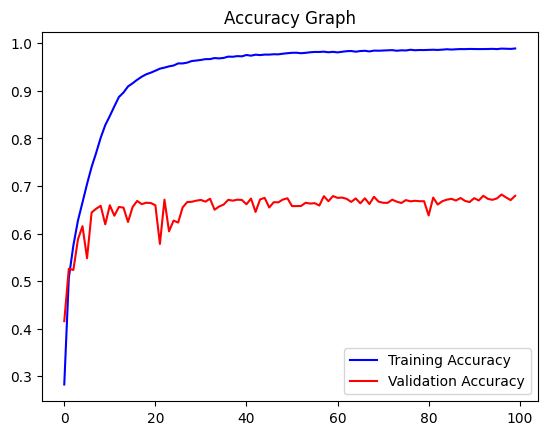

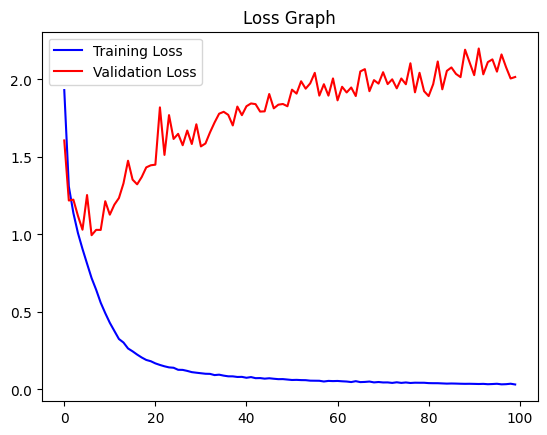

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.savefig(f'plots/AccuracyGraph_{model.name}_{DATASET}.png', bbox_inches='tight')
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.savefig(f'plots/LossGraph_{model.name}_{DATASET}.png', bbox_inches='tight')

## Accuracy, F1, Precision, Recall

In [117]:
from tensorflow.keras.models import load_model

# model = load_model('models/model.keras')

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)

107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step


In [118]:
y_pred = np.array([np.eye(len(row))[row.argmax()] for row in y_pred_prob])

In [119]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

       angry       0.58      0.56      0.57       454
     disgust       0.68      0.73      0.71        56
        fear       0.48      0.46      0.47       465
       happy       0.85      0.85      0.85       852
     neutral       0.58      0.66      0.62       563
         sad       0.56      0.54      0.55       642
    surprise       0.80      0.77      0.78       388

   micro avg       0.66      0.66      0.66      3420
   macro avg       0.65      0.65      0.65      3420
weighted avg       0.66      0.66      0.66      3420
 samples avg       0.66      0.66      0.66      3420



In [120]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(acc)

0.6578947368421053


## Confusion matrix

<Figure size 640x480 with 0 Axes>

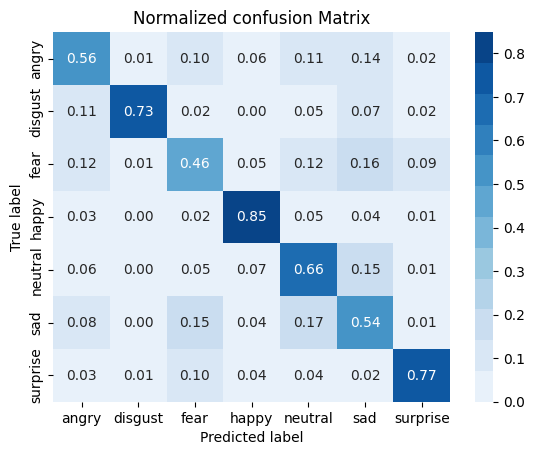

<Figure size 640x480 with 0 Axes>

In [121]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(
    le.inverse_transform(np.argmax(y_test, axis=1)),
    le.inverse_transform(np.argmax(y_pred, axis=1)),
    normalize='true'
)

sns.heatmap(
    cm,
    annot=True,
    xticklabels=labels,
    yticklabels=labels,
    cmap=sns.color_palette('Blues', 12),
    fmt='.2f'
)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Normalized confusion Matrix')
plt.savefig(f'plots/ConfusionMatrix_{model.name}_{DATASET}.png', bbox_inches='tight')
plt.figure()

## Test with Image Data

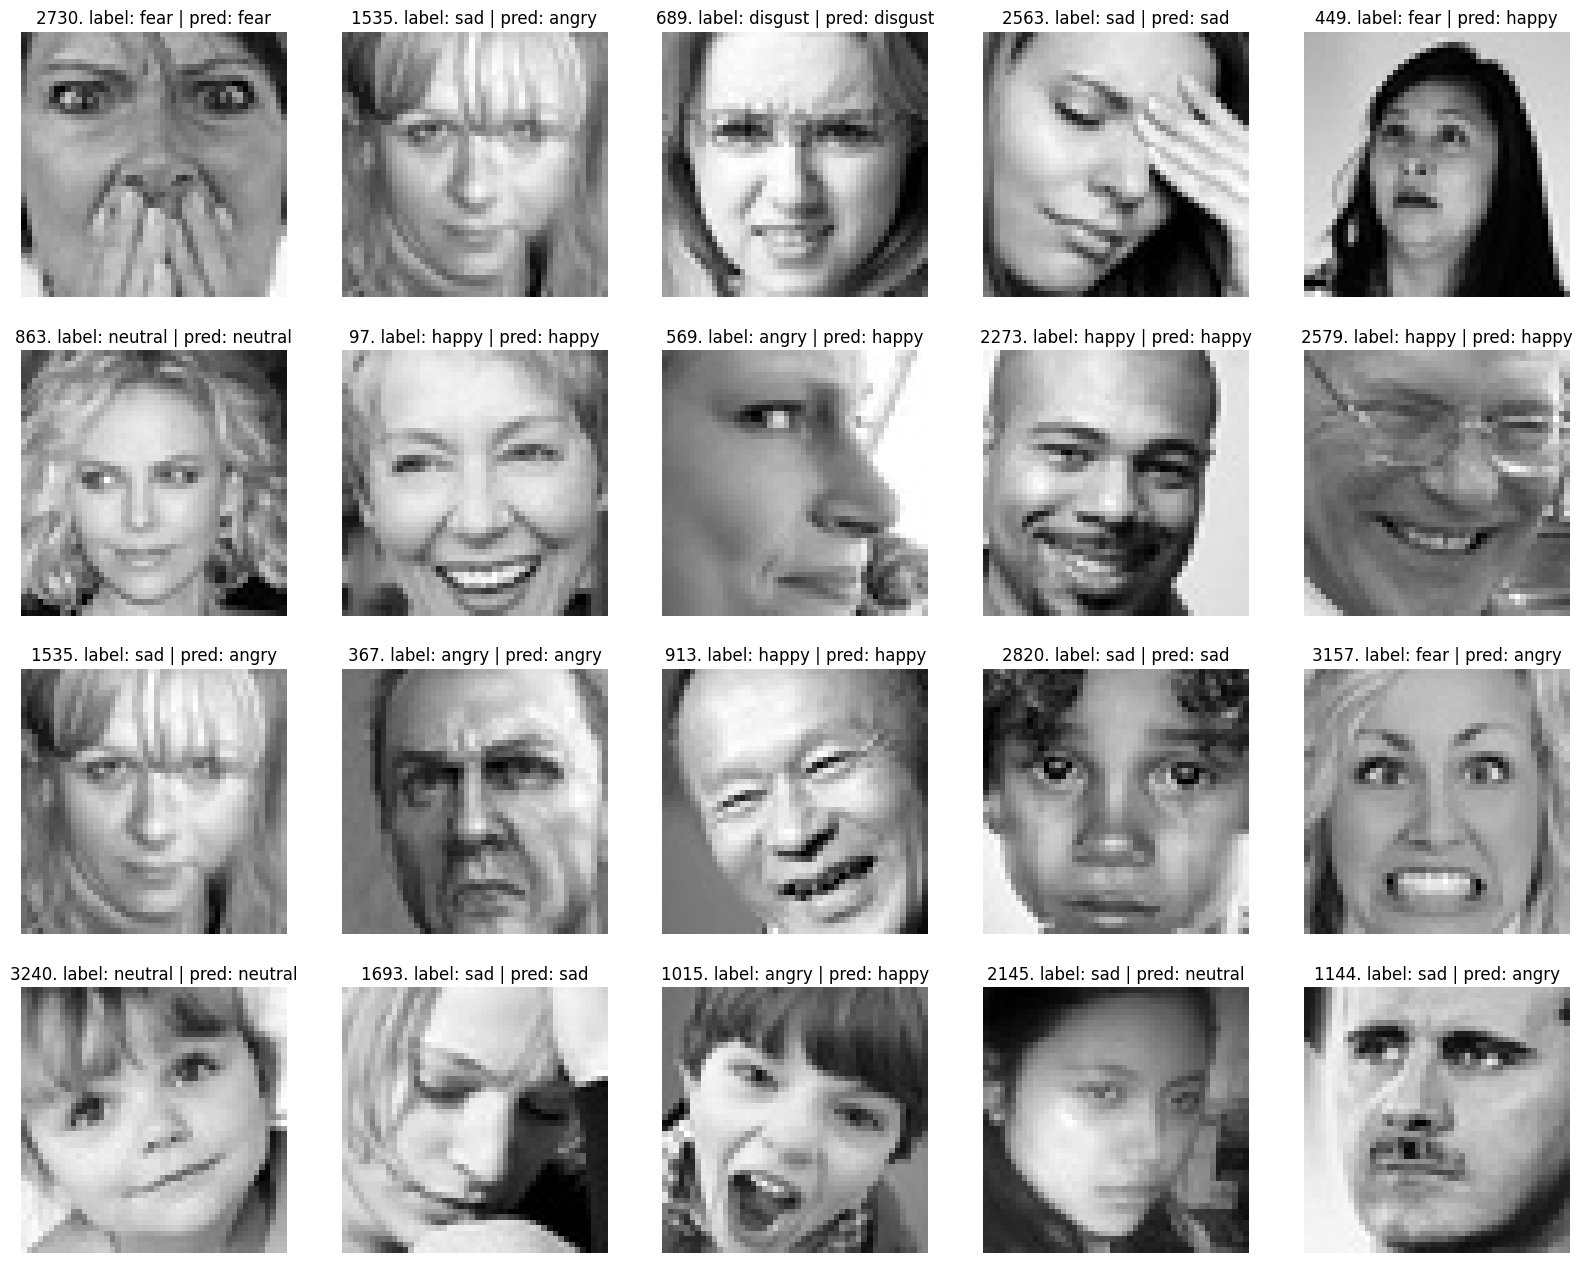

In [122]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]

    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_label = le.inverse_transform([pred.argmax()])[0]
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')